Get the masks from qupath by going to stardist github, they have link to .groovy script that you drag and drop into qupath to get the ground truth masks

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [2]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [8]:
#Read input image and corresponding mask names
X = sorted(glob(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\tiles256\*.tif'))
Y = sorted(glob(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\stardist_segmented_jsons\qupath_pro\ground_truth\masks\*.tif'))

#Read images and masks using their names.
#We are using tifffile library to read images as we have tif images.
X = list(map(imread,X))
Y = list(map(imread,Y))

In [63]:
#Split to train and val

assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:   7
- training:         6
- validation:       1


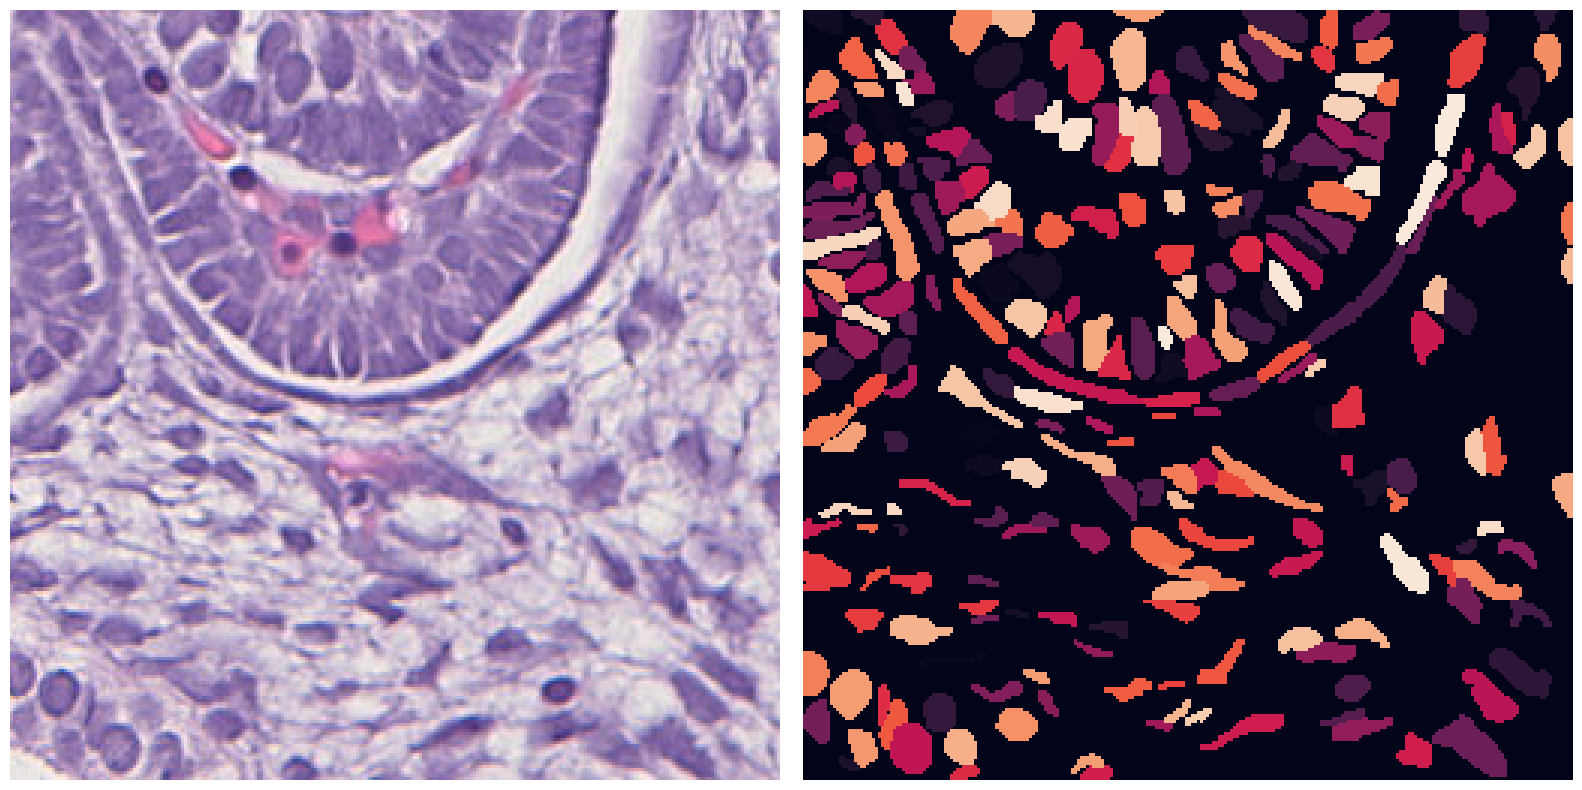

In [64]:
#PLot image and label for some images - sanity check
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


i = min(9, len(X)-1)

img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
show_tile_segmented(img,lbl)

In [65]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [66]:
#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [67]:
if use_gpu:
    print('Using gpu')
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    # limit_gpu_memory(0.8)
    # alternatively, try this:
    limit_gpu_memory(None, allow_growth=True)

Using gpu


In [68]:
#Save model to the specified directory
model = StarDist2D(conf, name='monkey_tile_trained_v2', basedir=r'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


base_model.py (149): output path for model already exists, files may be overwritten: C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist\monkey_tile_trained_v2


In [69]:
#Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [13. 11.]
network field of view :  [94 94]


In [70]:
#Define a few augmentation methods
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [71]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

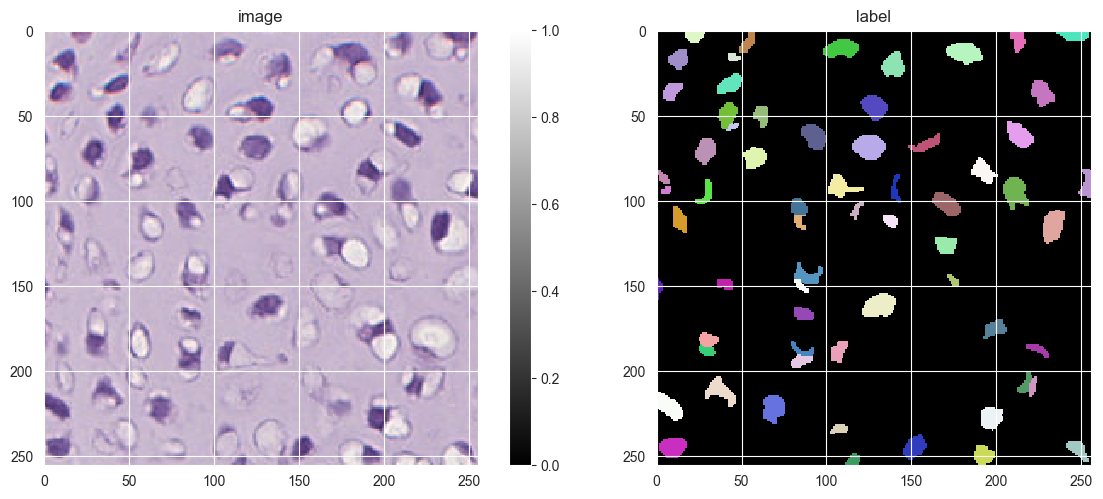

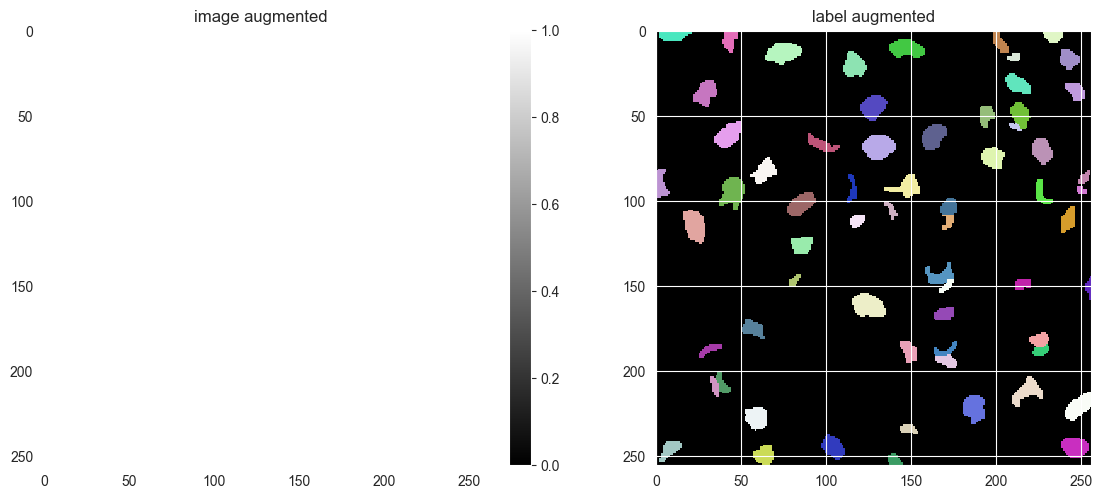

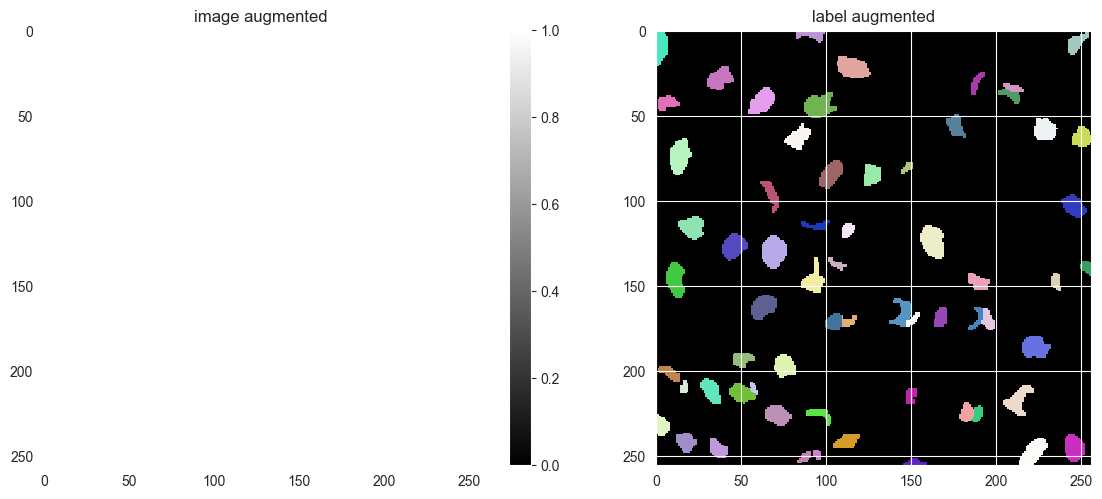

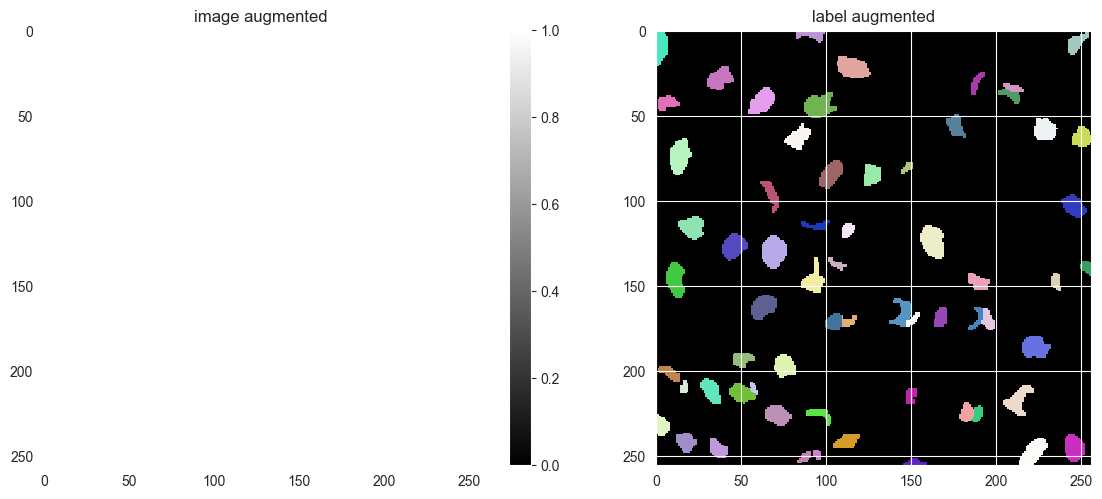

In [72]:
# plot some augmented examples
img, lbl = X[4],Y[4]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

In [73]:
from csbdeep.data import Normalizer, normalize_mi_ma

class MyNormalizer(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False

# mi, ma = np.percentile(img[::8], [1,99.8])                      # compute percentiles from low-resolution image
# mi, ma = np.percentile(img[13000:16000,13000:16000], [1,99.8])  # compute percentiles from smaller crop
mi, ma = 0, 255                                                   # use min and max dtype values (suitable here)
normalizer = MyNormalizer(mi, ma)

In [74]:
normalized_X_trn = []
for im in X_trn:
    normalized_X_trn.append(normalizer(im, axes=False))

normalized_X_val = []
for im in X_val:
    normalized_X_val.append(normalizer(im, axes=False))

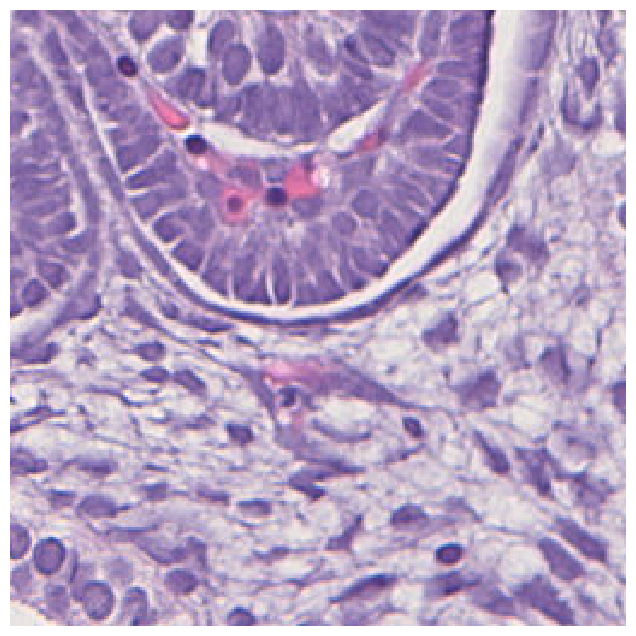

In [77]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_X_val[0])
plt.show()

In [78]:
model.train(normalized_X_trn, Y_trn, validation_data=(normalized_X_val,Y_val), augmenter=augmenter, epochs=20, steps_per_epoch=100)

Epoch 1/20
Cause: Unable to locate the source code of <function _gcd_import at 0x000001D4ECE61310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x000001D4ECE61310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x000001D4ECE61310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 7s 51ms/step - loss: 1.2932 - prob_loss: 0.4866 - dist_loss: 4.0332 - prob_kld: 0.3100 - dist_relevant_mae: 4.0330 - dist_relevant_mse: 27.1586 - dist_dist_iou_metric: 0.1192 - val_loss: 1.0299 - val_prob_loss: 0.4952 - val_dist_loss: 2.6736 - val_prob_kld: 0.3128 - val_dist_relevant_mae: 2.6734 - val_dist_relevant_mse: 14.1084 - val_dist_dist_iou_metric: 0.2305 - lr: 3.0000e-04
Epoch 2/20
100/100 [==============================]

In [79]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(normalized_X_val, Y_val)

# do on validation instead


NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:00<00:00, 58.14it/s, 0.626 -> 0.337]


Using optimized values: prob_thresh=0.625748, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.6257481130946939, 'nms': 0.4}

In [80]:
#Load saved model
my_model = StarDist2D(None, name='monkey_tile_trained_v2', basedir=r'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.625748, nms_thresh=0.4.


In [30]:
model=my_model

In [83]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(normalized_X_val)]

100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


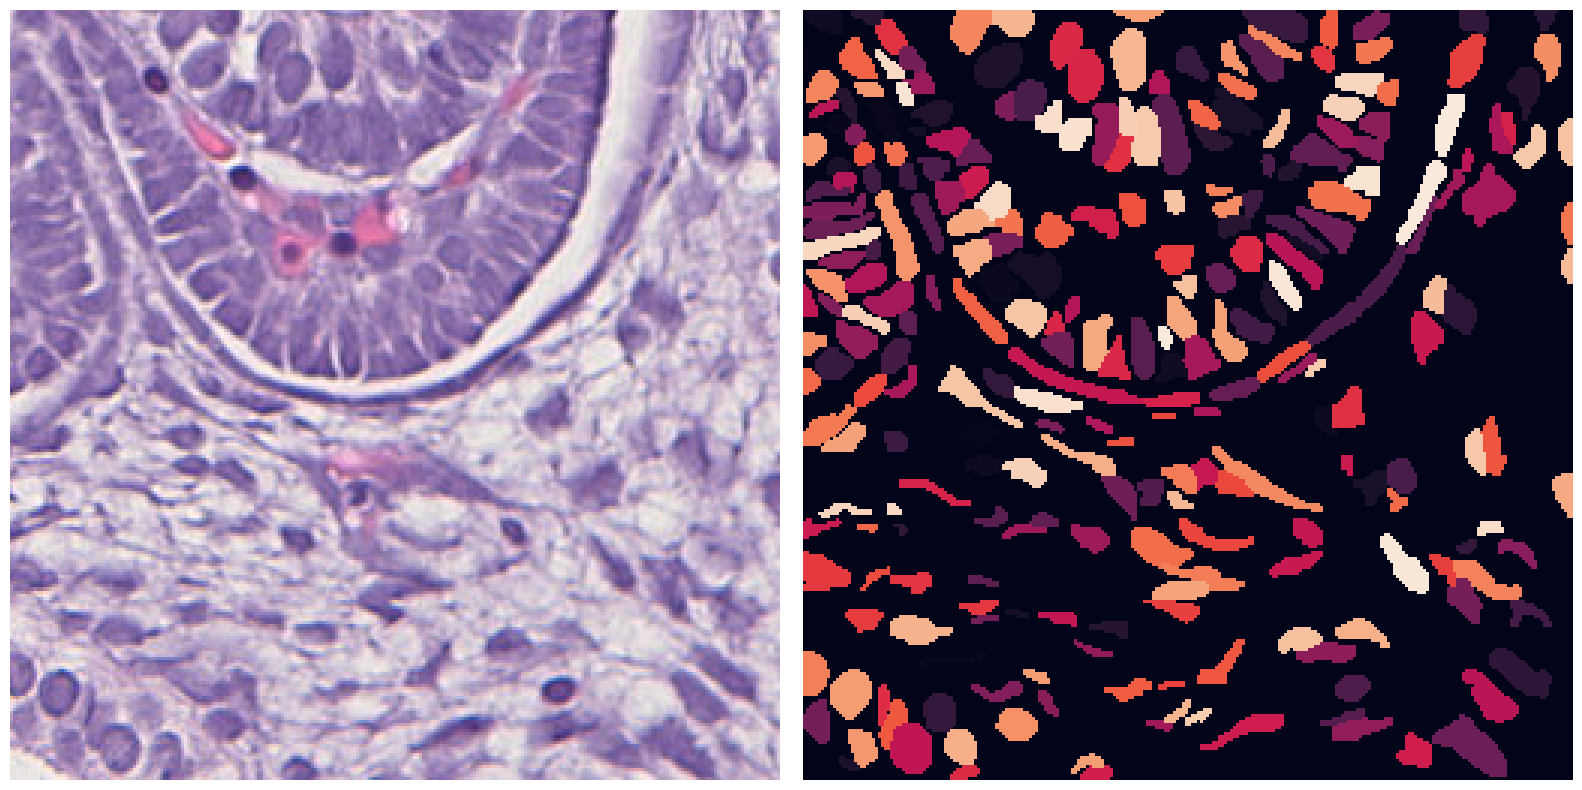

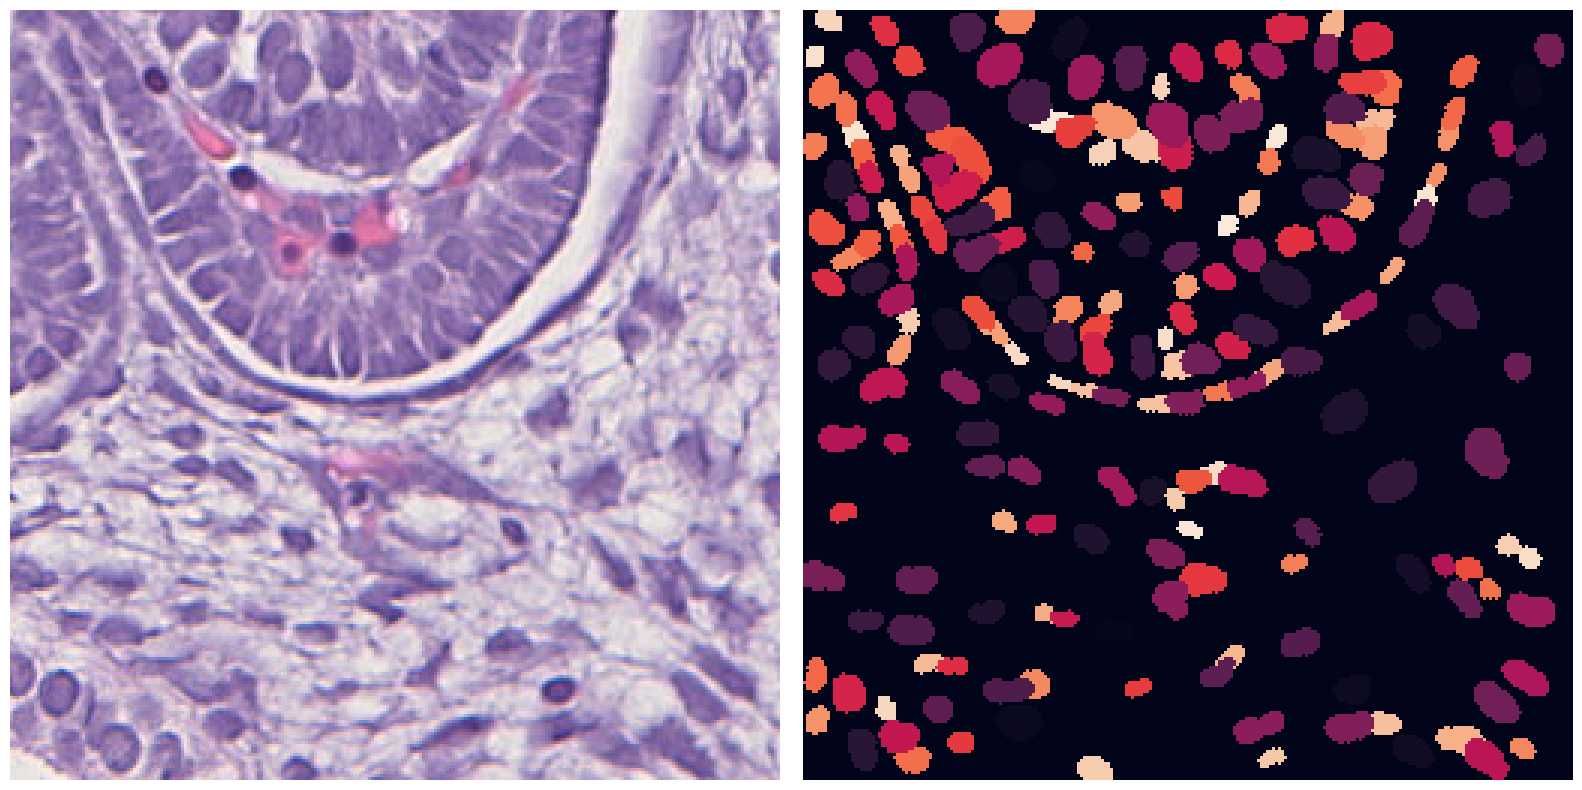

100%|██████████| 9/9 [00:00<00:00, 428.59it/s]


DatasetMatching(criterion='iou', thresh=0.5, fp=89, tp=125, fn=141, precision=0.5841121495327103, recall=0.4699248120300752, accuracy=0.352112676056338, f1=0.5208333333333334, n_true=266, n_pred=214, mean_true_score=0.31017905787417765, mean_matched_score=0.66006103515625, panoptic_quality=0.3437817891438802, by_image=False)

In [84]:
#PLot original labels and predcitions
show_tile_segmented(X_val[0],Y_val[0])
show_tile_segmented(X_val[0],Y_val_pred[0])


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]